In [ ]:
!apt-get update && apt-get install -y python3-opencv 

In [5]:
%pip install diffusers==0.20.0 \
  pillow==10.0.0 \
  torch==2.0.1 \
  opencv-python==4.8.0.76 \
  torchvision==0.15.2 \
  controlnet-aux==0.0.6 \
  accelerate==0.21.0 \
  transformers==4.31.0

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


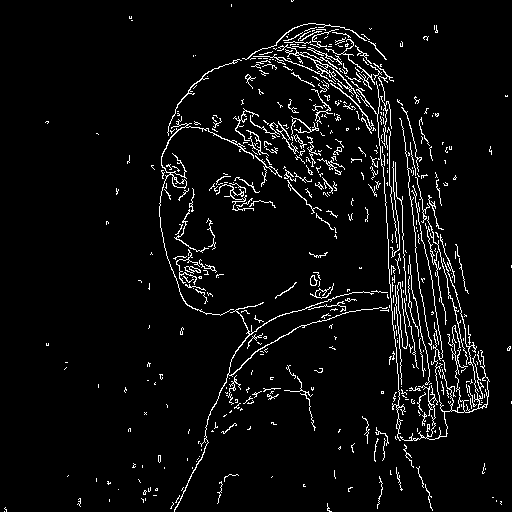

In [11]:
from diffusers import StableDiffusionControlNetPipeline
#from diffusers.utils import load_image
from diffusers.utils.testing_utils import load_image

# Let's load the popular vermeer image
image = load_image("https://dsoaws.s3.amazonaws.com/gaia/11_multimodal/img/input_image_vermeer.png")
# Render the canny edge map for this particular image
import cv2
from PIL import Image
import numpy as np

image = np.array(image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)

canny_image.save("./canny_image.png")

canny_image

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

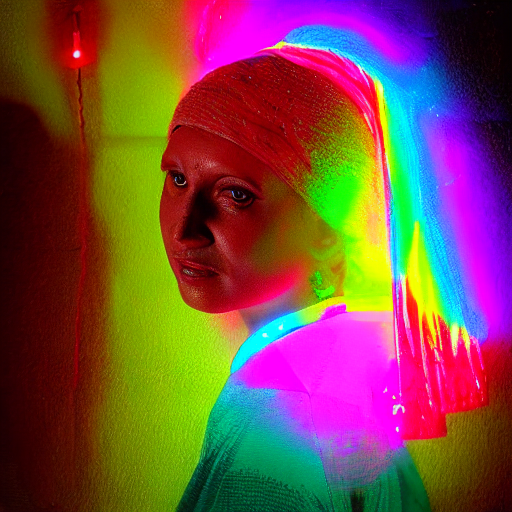

In [12]:
from diffusers import StableDiffusionControlNetPipeline
from diffusers import ControlNetModel
import torch

canny = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-canny", 
#    torch_dtype=torch.float16
)

sd_pipe = StableDiffusionControlNetPipeline.from_pretrained(      
    "runwayml/stable-diffusion-v1-5", 
    controlnet=canny, 
#    torch_dtype=torch.float16
)

generator = torch.manual_seed(0)

out_image = sd_pipe(
    "disco dancer with colorful lights", 
    num_inference_steps=20, 
    generator=generator, 
    image=canny_image
).images[0]

out_image.save("./out_image.png")

out_image

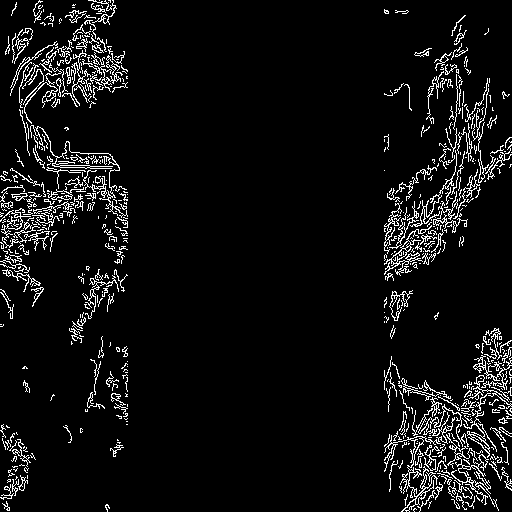

In [13]:
from PIL import Image
import cv2
import numpy as np
#from diffusers.utils import load_image
from diffusers.utils.testing_utils import load_image

canny_image = load_image("https://dsoaws.s3.amazonaws.com/gaia/11_multimodal/img/landscape.png")
canny_image = np.array(canny_image)
low_threshold = 100
high_threshold = 200
canny_image = cv2.Canny(canny_image, 
  low_threshold, 
  high_threshold)


# zero out middle columns of image where pose will be overlayed
zero_start = canny_image.shape[1] // 4
zero_end = zero_start + canny_image.shape[1] // 2
canny_image[:, zero_start:zero_end] = 0
canny_image = canny_image[:, :, None]
canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)
canny_image = Image.fromarray(canny_image)

canny_image.save("./canny_image_masked.png")

canny_image

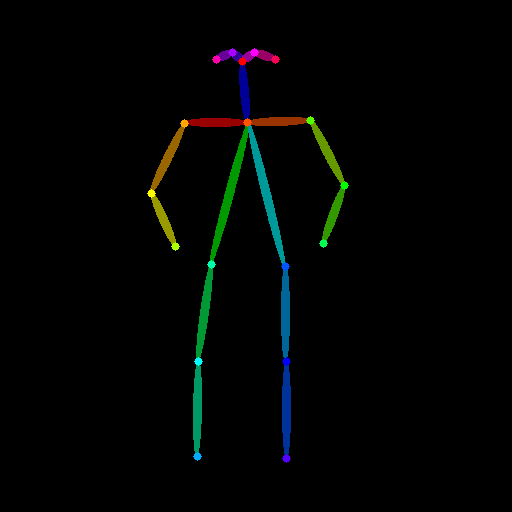

In [16]:
from controlnet_aux import OpenposeDetector
#from diffusers.utils import load_image
from diffusers.utils.testing_utils import load_image

openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

openpose_image = load_image(
"https://dsoaws.s3.amazonaws.com/gaia/11_multimodal/img/person.png"
)
openpose_image = openpose(openpose_image)

openpose_image.save("./openpose.png")

openpose_image

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

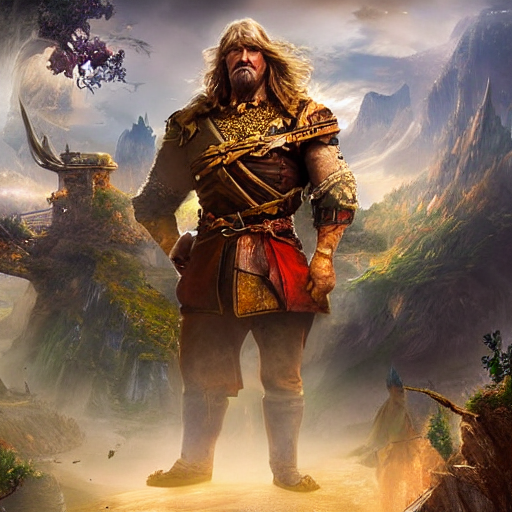

In [15]:
from diffusers import StableDiffusionControlNetPipeline
from diffusers import ControlNetModel
import torch

controls = [      
  ControlNetModel\
    .from_pretrained("lllyasviel/sd-controlnet-openpose",  
#      torch_dtype=torch.float16
),
  ControlNetModel\
    .from_pretrained("lllyasviel/sd-controlnet-canny", 
#      torch_dtype=torch.float16
)
]
pipe = StableDiffusionControlNetPipeline\
  .from_pretrained(
    "runwayml/stable-diffusion-v1-5", 
    controlnet=controls, 
#    torch_dtype=torch.float16
)
prompt = "a giant standing in a fantasy landscape, best quality"
negative_prompt = "monochrome, lowres, bad anatomy, worst quality, low quality"
generator = torch.Generator(device="cpu").manual_seed(1)
images = [openpose_image, canny_image]

image = pipe(
    prompt,
    images,
    num_inference_steps=20,
    generator=generator,
    negative_prompt=negative_prompt,
    controlnet_conditioning_scale=[1.0, 0.8],
).images[0]

image.save("./output.png")

image 
